In [ ]:
# Copyright 2024 NASA
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Rice mapping in Bhutan with U-Net using high resolution satellite imagery

### This notebook shows an example of exporting patches needed for training Deep Neural Networks (DNN)

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/SERVIR/servir-aces/blob/main/notebooks/count_sample_size.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/SERVIR/servir-aces/blob/main/notebooks/count_sample_size.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
</table>
</br>
</br>
</br>

This notebook is also available in this github repo: https://github.com/SERVIR/servir-aces. Navigate to the `notebooks` folder.

## Setup environment

In [1]:
!pip install "servir-aces[extra]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 34.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89.7 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.0/152.0 kB 12.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 47.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 676.9/676.9 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 64.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.5/173.5 kB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━

Restart the session if needed

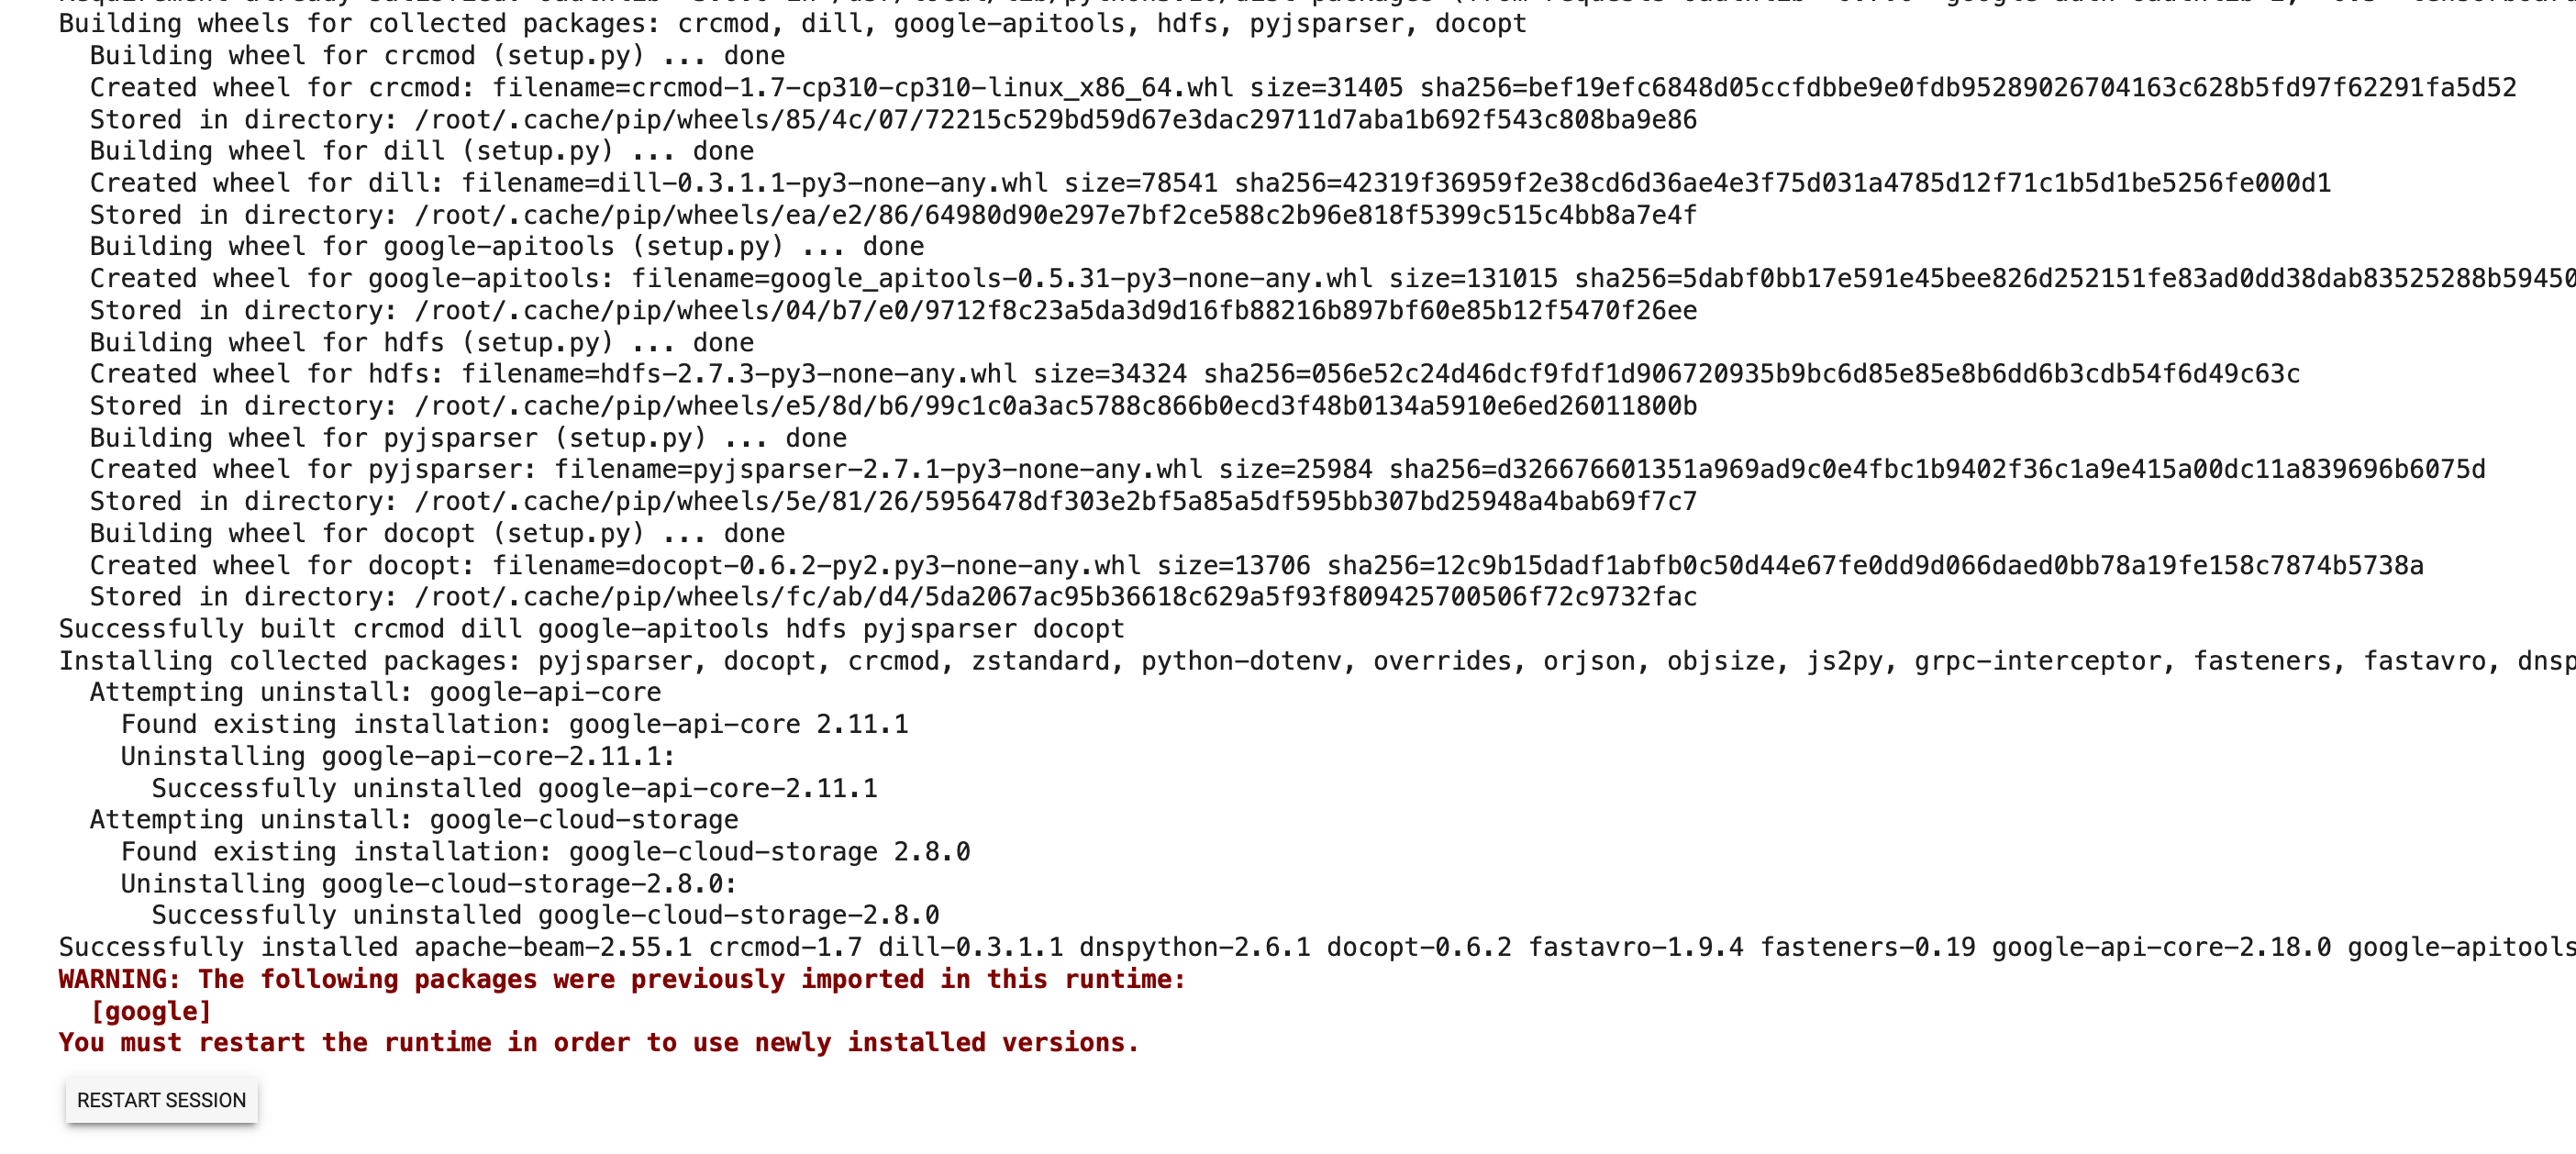

In [1]:
!git clone https://github.com/SERVIR/servir-aces

Cloning into 'servir-aces'...
remote: Enumerating objects: 731, done.
remote: Counting objects: 100% (90/90), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 731 (delta 55), reused 40 (delta 40), pack-reused 641
Receiving objects: 100% (731/731), 3.35 MiB | 17.00 MiB/s, done.
Resolving deltas: 100% (478/478), done.


Now the repo is downloaded. We will create an environment file file to place point to our training data and customize parameters for the model. To do this, we make a copy of the `.env.example` file provided.

Under the hood, all the configuration provided via the environment file are parsed as a config object and can be accessed programatically.

Note current version does not expose all the model intracacies through the environment file but future version may include those depending on the need.

## Setup config file variables

In [2]:
!cp servir-aces/.env.example servir-aces/config.env

Okay, now we have the `config.env` file, we will use this to provide our environments and parameters.

Note there are several parameters that can be changed. Let's start by changing the BASEDIR as below.

```
BASEDIR = "/content/"
```

For the prediction, we are using growing season and pre-growing season information. Thus, we have 8 optical bands, namely `red_before`, `green_before`, `blue_before`, `nir_before`, `red_during`, `green_during`, `blue_during`, and  `nir_during`. In adidition, you can use `USE_ELEVATION` and `USE_S1` config to include the topographic and radar information. Since currently we are not including these, so we won't be settting these config values. Similarly, we are using 256x256 pixels at 10m resolution, so let's also change that.

```
# For model training, USE_ELEVATION extends FEATURES with "elevation" & "slope"
# USE_S1 extends FEATURES with "vv_asc_before", "vh_asc_before", "vv_asc_during", "vh_asc_during",
# "vv_desc_before", "vh_desc_before", "vv_desc_during", "vh_desc_during"
# In case these are not useful and you have other bands in your training data, you can do set
# USE_ELEVATION and USE_S1 to False and update FEATURES to include needed bands
USE_ELEVATION = False
USE_S1 = False

SCALE = 10

PATCH_SHAPE = (256, 256)
```

Next, we will specify the `DATA_OUTPUT_DIR`. The `DATA_OUTPUT_DIR` is the main folder where the training dataset will be saved. Then training, testing, and validation sub-folder are created within the `DATA_OUTPUT_DIR` which are named as `training_{percentage_of_total}`, `testing_{percentage_of_total}`, and `validation_{percentage_of_total}`. In this exercise, we will save our data to the cloud bucket, so we will also specify the `GCS_BUCKET` parameter and `GCS_PROJECT`.

```
DATA_OUTPUT_DIR = "chapter-1/training_data"
GCS_BUCKET = "dl-book"
GCS_PROJECT = "servir-ee"
```

## Update the config file programtically

Let's make a dictionary so we can change these config settings programatically.

In [3]:
DATA_OUTPUT_DIR = "chapter-1/training_data" # @param {type:"string"}
GCS_BUCKET = "dl-book" # @param {type:"string"}
GCS_PROJECT = "servir-ee"  # @param {type:"string"}
USE_ELEVATION = "False" # @param {type:"string"}
USE_S1 = "False" # @param {type:"string"}
SCALE = "10" # @param {type:"string"}
PATCH_SHAPE = "(256, 256)" # @param {type:"string"}


In [4]:
config_settings = {
    "DATA_OUTPUT_DIR" : DATA_OUTPUT_DIR,
    "GCS_BUCKET": GCS_BUCKET,
    "GCS_PROJECT": GCS_PROJECT,
    "USE_ELEVATION": USE_ELEVATION,
    "USE_S1": USE_S1,
    "SCALE": SCALE,
    "PATCH_SHAPE": PATCH_SHAPE,
}


In [5]:
import dotenv

config_file = "servir-aces/config.env"

for config_key in config_settings:
    dotenv.set_key(dotenv_path=config_file,
                   key_to_set=config_key,
                   value_to_set=config_settings[config_key]
                   )


## Load config file variables

In [6]:
from aces import Config, EEUtils

In [7]:
# config_file = "/content/servir-aces/config.env"
config = Config(config_file, override=True)

BASEDIR: aces
DATADIR: aces/data
using features: ['red_before', 'green_before', 'blue_before', 'nir_before', 'red_during', 'green_during', 'blue_during', 'nir_during']
using labels: ['class']


In [8]:
config.DATA_OUTPUT_DIR

'chapter-1/training_data'

Most of the config in the `config.env` is now available via the config instance. Let's check few of them here.

In [9]:
config.TRAINING_DIR, config.BATCH_SIZE, config.FEATURES

(PosixPath('aces/data/training'),
 64,
 ['red_before',
  'green_before',
  'blue_before',
  'nir_before',
  'red_during',
  'green_during',
  'blue_during',
  'nir_during'])

## Setup proper permissions

In [10]:
# Import, authenticate and initialize the Earth Engine library.
import ee
ee.Authenticate()
EEUtils.initialize_session(use_highvolume=True, project=config.GCS_PROJECT)


In [11]:
!earthengine set_project {config.GCS_PROJECT}

Successfully saved project id


In [12]:
# Cloud authentication.
from google.colab import auth
auth.authenticate_user()

In [13]:
!gcloud config set project {config.GCS_PROJECT}

Updated property [core/project].


## Understanding script for the training data generation

We will be using the `generate_training_patches.py` script within the `servir-aces` folder. This script makes it easier so we can pass our `Config`, and at the same time use different modes for training data generation. We will be using `apache-beam` so exports could be parallelized.

### Modes of Training Data Exports

#### Neighbourhood or patch exports

The modes, they represents different techniques to export and have their own pros and cons. Currently, at the time of writing this, there are four modes provided. Three of the modes `"patch"`, `"patch_seed"`, and `"neighborhood"` or `"neighbourhood"` can be used to export the patch (more than 1x1 pixels). The "`patch`" mode uses [`image.getDownloadURL`](https://developers.google.com/earth-engine/apidocs/ee-image-getdownloadurl) method to get the patch. The patch retrievel using [`computePixel`](https://developers.google.com/earth-engine/apidocs/ee-data-computepixels) is a work in [progress](https://github.com/SERVIR/servir-aces/blob/main/aces/ee_utils.py#L467). This method randomly splits the given label point. Use this method for small data points or in small batches, else `ee.ee_exception.EEException: Too Many Requests: Request was rejected because the request rate or concurrency limit was exceeded.` is commonly encountered.

Similarly, the `"patch_seed"` is very similar to the `"patch"` mode except that there is an extra argument that can be passed with `--split_directory` which takes a value of either `training`, `testing` or `validation` (default to `training`). This will run the tile export in the specified `split_directory`.

Both `"patch"` and `"patch_seed"` produces number of files which are equal to the CPU available.  

The `"neighborhood"` or `"neighbourhood"` uses [`neighborhoodToArray`](https://developers.google.com/earth-engine/apidocs/ee-image-neighborhoodtoarray) and `sample` method to compute the patch. This will start the export in the `Tasks` tab in Google Earth Engine (GEE). As with others, be careful when running this. For large number of tasks, you will get `ee.ee_exception.EEException: Too many tasks already in the queue (3000). Please wait for some of them to complete.` error. As with `"patch_seed"` mode, you can specify the `split_directory` to run on the particular split. This will produce as much files as the number of samples, since each sample are exported individually.

#### Point exports

For point based algorithms like DNN, we need to be able to export point data. In this case, we use the `"point"` mode. This uses [`sample`](https://github.com/SERVIR/servir-aces/blob/main/aces/ee_utils.py#L357) method for this.

## Running the script for the training data generation

We will run one complete run in this exercise, but I will show how to run other modes as well.

I have the sample_locations already. Each of the location needs a "random" property which will be used for split ratio. We use argumnets passed to provide various settings to the script.

Since I have the "random" property assign in each of my sample location, I will use the `"patch_seed"` mode to allow tiling on these sub-directory split. For training `directory`, you would do as below. Here `-m` specifies the modes, `--config` specifies the config file and `--split_directory` specifies the directory split for saving. Other available arguments are `--sample_data` which is the sampled dataset to load from. Only provide the path only to the `ee.FeatureCollection` to load from for the `--sample_data`; `--label_data` which is the label data to load from, and `--image_data` is the image data to load from. You can either provide the path or directly the `ee.Image` object to load from.

In addition, by default, 70\% is used for training, 10\% is used for testing the trained model, and the final 20\% is used for testing the trained model with testing dataset which are never seen by the model before. Ways to modify this percentage allocation will be available in the future versions.

In [14]:
# !python servir-aces/workflow/v2/generate_training_patches.py -m patch_seed --config config_file --split_directory training

In [15]:
!python servir-aces/workflow/v2/generate_training_patches.py -m patch_seed --config config_file --split_directory testing

2024-04-23 16:11:32.157258: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-23 16:11:32.157374: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-23 16:11:32.159202: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-23 16:11:33.951920: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Program started..
No dataset specified, defaulting to what we have here.
No label dataset specified, defaulting to what we have here.
BASEDIR: aces
DATADIR: aces/data
using features: ['red_before', 'green_before', 'blue_before', 'nir_before'

In [16]:
# !python servir-aces/workflow/v2/generate_training_patches.py -m patch_seed --config config_file --split_directory validation